## Use of different Aggregators

This notebook shows how to use different Aggregators.

When you start this tutorial you should either have an account and project in FEDn Studio, or have deployed a FEDn in pseudo-distributed  mode. You should also have created the compute package and the initial model, see README.md for instructions.

In [1]:
from fedn import APIClient
import time
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

We make a client connection to the FEDn API service. Here we assume that FEDn is deployed locally in pseudo-distributed mode with default ports. To connect to Studio, generate an API token from the UI, and retrive the controller host URI from the Dashboard.  

In [2]:
DISCOVER_HOST = '127.0.0.1'
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

Initialize FEDn with the compute package and seed model. Note that these files needs to be created separately by follwing instructions in the README.

In [3]:
client.set_active_package('package.tgz', 'numpyhelper')
client.set_active_model('seed.npz')
seed_model = client.get_active_model()
print(seed_model)

{'committed_at': 'Sat, 13 Apr 2024 18:44:33 GMT', 'id': '661ad2919c2e200bea276f77', 'key': 'models', 'model': '9072741c-383d-47a2-89b5-6e7608ddb80b', 'parent_model': None, 'session_id': None}


### FedAvg

In [11]:
session_id = "experiment_fedavg"

session_config = {
                    "helper": "numpyhelper",
                    "id": session_id,
                    "model_id": seed_model['model'],
                    "rounds": 10
                 }

result_fedavg = client.start_session(**session_config)

# We wait for the session to finish
while not client.session_is_finished(session_config['id']):
    time.sleep(2)

### FedAdam

Here we use the FedOpt family of aggregation algorithms. FEDn support adam, yogi and adagrad as server side optimizers. In the session_config below we illustrate how to set hyperparamters (will be valid for this session). The values below are actually the default values and are passed here for illustrative purposes.

**Note that the server side-momentum terms are only retained within one session - each new session you will re-initialize the optimizer to default values.** 

In [6]:
session_id = "experiment_fedadam"

session_config = {
                    "helper": "numpyhelper",
                    "id": session_id,
                    "aggregator": "fedopt",
                    "aggregator_kwargs": {
                        "serveropt": "adam",
                        "learning_rate": 1e-3,
                        "beta1": 0.9,
                        "beta2": 0.99,
                        "tau": 1e-4
                        },
                    "model_id": seed_model['model'],
                    "rounds": 1
                 }

result_fedadam = client.start_session(**session_config)

# We wait for the session to finish
while not client.session_is_finished(session_config['id']):
    time.sleep(2)

### FedYogi

In [12]:
session_id = "experiment_fedyogi"

session_config = {
                    "helper": "numpyhelper",
                    "id": session_id,
                    "aggregator": "fedopt",
                    "aggregator_kwargs": {
                        "serveropt": "yogi",
                        },
                    "model_id": seed_model['model'],
                    "rounds": 1
                 }

result_fedyogi = client.start_session(**session_config)
while not client.session_is_finished(session_config['id']):
    time.sleep(2)

### FedAdaGrad

In [8]:
session_id = "experiment_fedadagrad"

session_config = {
                    "helper": "numpyhelper",
                    "id": session_id,
                    "aggregator": "fedopt",
                    "aggregator_kwargs": {
                        "serveropt": "adagrad",
                        },           
                    "model_id": seed_model['model'],
                    "rounds": 1
                 }

result_fedadagrad = client.start_session(**session_config)
while not client.session_is_finished(session_config['id']):
    time.sleep(2)

Next, we get the model trail, retrieve all model validations from all clients, extract the training accuracy metric, and compute its mean value accross all clients.

In [13]:
session_id = "experiment_fedavg"
models = client.get_model_trail()

acc = []
for model in models:
    
    model_id = model["model"]
    validations = client.get_validations(model_id=model_id)

    a = []
    for validation in validations['result']: 
        metrics = json.loads(validation['data'])
        a.append(metrics['training_accuracy'])
        
    acc.append(a)

mean_acc = [np.mean(x) for x in acc]

/Users/andreash/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/andreash/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


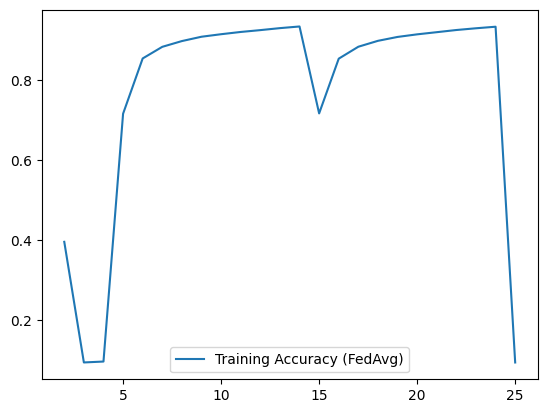

In [14]:
x = range(1,len(mean_acc)+1)
plt.plot(x, mean_acc)
plt.legend(['Training Accuracy (FedAvg)'])